In [1]:
using DrWatson

In [2]:
include(srcdir("rdpg.jl"))
using Main.rdpg
using LinearAlgebra, Plots, ProgressMeter, Random, Pipe
using PersistenceDiagrams, Ripserer, Statistics, StatsBase

In [3]:
function generate_sbm_sparse(n, k, p, r)
    f = (x, y) -> (r + p * (x == y)) * (log(n) / sqrt(n))
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function generate_data(n, ϵ, params, method=:dense)
    if method == :dense
        A = generate_sbm_dense(n, params.clust, params.p, params.r)
    else
        A = generate_sbm_sparse(n, params.clust, params.p, params.r)
    end

    X, _, _ = rdpg.spectralEmbed(A, d=params.d, restarts=10000)
    # Add small perturbation to avoid degenerate simplices in Alpha complex
    X = X .+ randn(size(X)...) .* 1e-10
    Dx = rdpg.diagram(X |> rdpg.subsample, dim_max=params.order)

    B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
    Y, _ = rdpg.spectralEmbed(B, d=params.d, restarts=10000)

    # Add small perturbation to avoid degenerate simplices in Alpha complex
    Y = Y .+ randn(size(Y)...) .* 1e-10
    Dy = rdpg.diagram(Y |> rdpg.subsample, dim_max=params.order)

    return rdpg.bottleneck_distance(Dx, Dy, order=params.order, p=params.q)
end


function one_sim(f, N, params, repeats=5, method=:dense)
    n  = length(N)
    m  = zeros(n)
    mn = zeros(n)
    s  = zeros(n)

    @showprogress for (i, n) in zip(eachindex(N), N)
        Random.seed!(2022)
        tmp = [generate_data(n, f(n), params, method)[1] for _ in 1:repeats]
        m[i] = median(tmp)
        s[i] = std(0.25 .* tmp)
        mn[i] = mean(tmp)
    end
    return m, s, mn
end

one_sim (generic function with 3 methods)

In [4]:
f1 = (; f=n -> log(n) / n^(2/3), name="k=0.66")
f2 = (; f=n -> log(n) / n^(1/3), name="k=0.33")

F = [f2, f1]

2-element Vector{NamedTuple{(:f, :name)}}:
 (f = var"#7#8"(), name = "k=0.33")
 (f = var"#5#6"(), name = "k=0.66")

In [5]:
theme(:default)
N = [500:500:9_500...;]
params = (; p=0.9, r=0.1, clust=3, d=3, order=1, q=Inf, ribbon=true)

(p = 0.9, r = 0.1, clust = 3, d = 3, order = 1, q = Inf, ribbon = true)

In [ ]:
sparse = Any[]
for f in F
    m, s, mn = one_sim(f.f, N, params, 10, :sparse)
    push!(sparse, [m, s, mn])
    GC.gc()
end

Progress: 100%|█████████████████████████████████████████| Time: 0:14:25
Progress: 100%|█████████████████████████████████████████| Time: 0:14:29


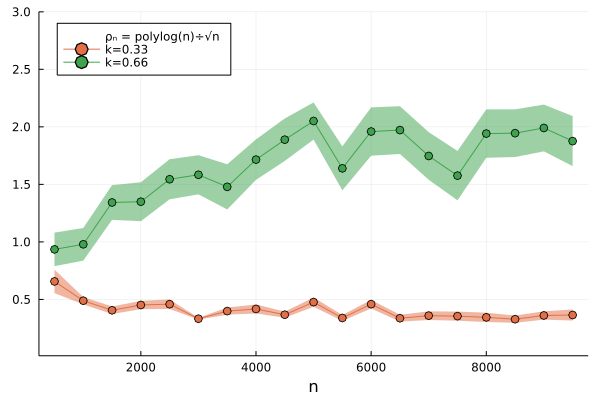

In [ ]:
plt_sparse = plot(N, x -> 0, xlabel="n", la=0, label="ρₙ = polylog(n)÷√n", legend=:topleft)
for (f, x) in zip(F, eachrow(sparse))
    plt_sparse = plot(plt_sparse, N, x[1][3], ribbon=x[1][2], label=f.name, m=:o)
end
plot(plt_sparse, ylim=(1e-2, 3.0), yscale=:identity)
# plt_sparse

In [ ]:
savefig(plot(plt_sparse, size=(600, 400)), plotsdir("sparse-k-alt.pdf"))